In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import sklearn.neighbors as skln
import gc
import pickle
import os

from lshexperiment import *

DATA_DIR = 'data'

if DATA_DIR is not None and not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

# rng = np.random.default_rng(seed=67)
plt.rcParams["figure.figsize"] = (7,4)
plt.rcParams['figure.dpi'] = 200

In [3]:
delta = 1/1000
n = 1000
d = 300 # at least log n ** 2?
r1 = d // 10
r2 = d // 5
# k = np.floor(-np.log(n) / np.log(1 - r2 / d))
# rho = np.log(1 - r1/d) / np.log(1 - r2/d)
# l = int(np.ceil(np.power(n, rho) * np.log(1/delta)))

In [4]:
n, l, k, rho, r1, r2

(1000, 181, 30.0, 0.4721647344828152, 30, 60)

## Success chance tests

In [18]:
points = np.zeros((n, d), dtype=int)

lsh = HammingLSH(points, r1, r2, delta)

In [27]:
grid = np.arange(r2 + 2)
vals = np.zeros(r2 + 2)
for dist in tqdm(grid):
    repeats = 100
    success = 0
    for j in range(repeats):
        for j in range(300):
            q = np.zeros(d, dtype=int)
            q[rng.choice(d, dist, replace=False)] = 1
            res = lsh.query(q)
            if res is None:
                success += 1
                break
    vals[dist] = success / repeats

  0%|          | 0/62 [00:00<?, ?it/s]

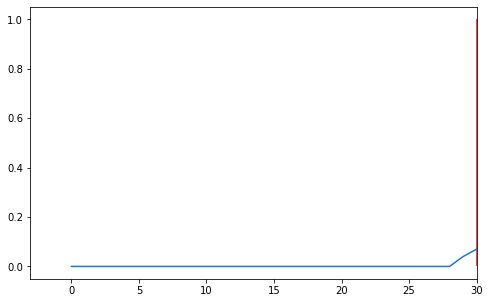

In [28]:
plt.plot(grid, vals)
plt.vlines([r1], 0, 1, colors=['red'])
plt.xlim(None, 30)
plt.show()

In [10]:
print("Success rate at r1:", vals[r1])

Success rate at r1: 1.0


In [ ]:
env = Environment()

point_params = {
    'n': 1000,
    'd': 300,
    'point_type': "zero",
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/1000,
    'seed_offset': 0,
    'r1': point_params['d'] // 10,
    'r2': point_params['d'] // 5
}

exp_params = {
    'alg_type': 'adaptive',
    'iter_num': 100,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
}

# Breaking hamming LSH faster

In [31]:
env = Environment()

point_params = {
    'n': 1000,
    'd': 300,
    'point_type': "zero",
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/1000,
    'seed_offset': 0,
    'r1': point_params['d'] // 10,
    'r2': point_params['d'] // 5
}

exp_params = {
    'alg_type': 'adaptive',
    'iter_num': 100,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
}

### Analysing dependance on t

In [33]:
t_grid = np.arange(0, lsh_params['r1'] + 1, 1)
new_exp_param = exp_params.copy()
new_exp_param['iter_num'] = 300
res = run_basic_grid_experiment(t_grid, 't', env, point_params, lsh_params, new_exp_param, DATA_DIR)

  0%|          | 0/31 [00:00<?, ?it/s]

In [34]:
data_succ_prob, data_queries = process_results(res, count_failures=False)
_, data_all_queries = process_results(res, count_failures=True)

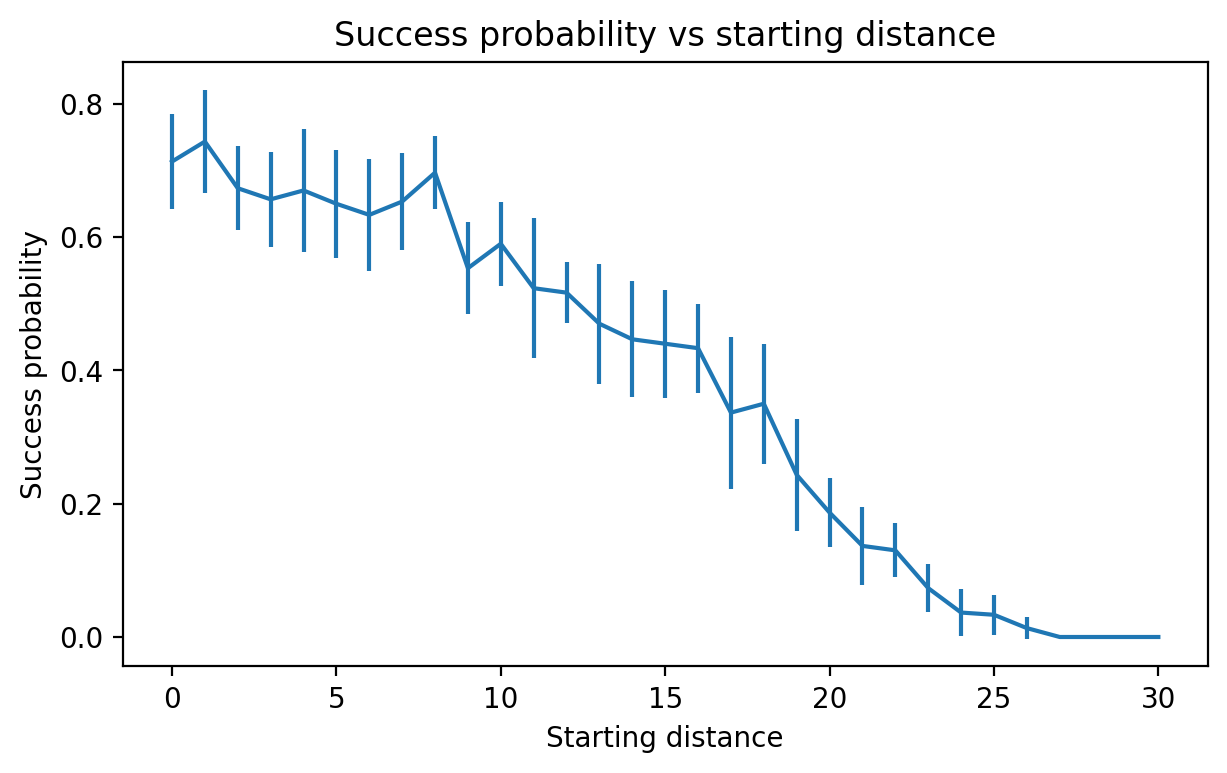

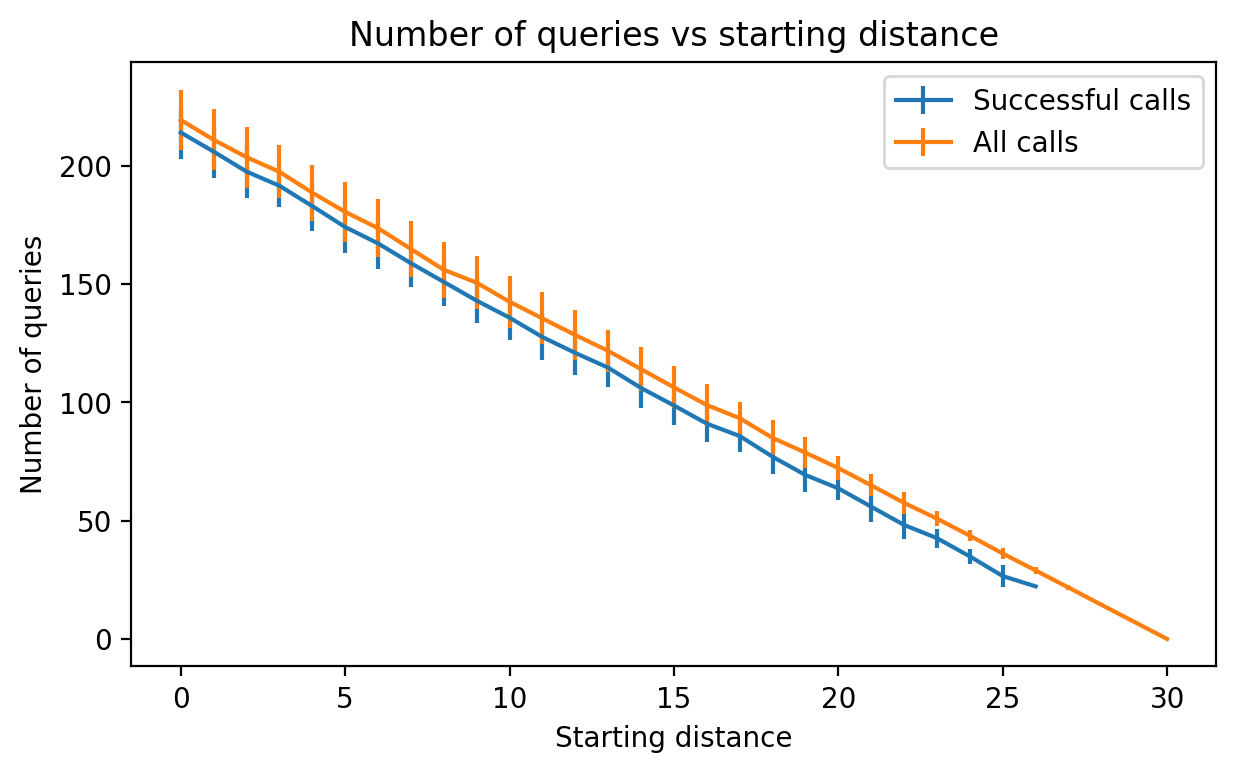

In [35]:
dist_grid = lsh_params['r1'] - t_grid
xlims = (np.min(dist_grid) - 1, np.max(dist_grid) + 1)

plt.errorbar(dist_grid, data_succ_prob[0], yerr=data_succ_prob[1])
# plt.xlim(xlims)
plt.title("Success probability vs starting distance")
plt.xlabel("Starting distance")
plt.ylabel("Success probability")
plt.show()

plt.errorbar(dist_grid, data_queries[0], yerr=data_queries[1], label="Successful calls")
plt.errorbar(dist_grid, data_all_queries[0], yerr=data_all_queries[1], label="All calls")
plt.legend()
# plt.xlim(xlims)
plt.title("Number of queries vs starting distance")
plt.xlabel("Starting distance")
plt.ylabel("Number of queries")
plt.show()

### Dependance on $t$ with random points

In [36]:
env = Environment()

point_params = {
    'n': 1000,
    'd': 300,
    'point_type': "random",
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/1000,
    'seed_offset': 0,
    'r1': point_params['d'] // 10,
    'r2': point_params['d'] // 5
}

exp_params = {
    'alg_type': 'adaptive',
    'iter_num': 200,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
}

In [37]:
t_grid = np.arange(0, lsh_params['r1'] + 1, 1)
res = run_basic_grid_experiment(t_grid, 't', env, point_params, lsh_params, exp_params, data_dir=DATA_DIR)

  0%|          | 0/31 [00:00<?, ?it/s]

In [38]:
data_succ_prob, data_queries = process_results(res, count_failures=False)
_, data_all_queries = process_results(res, count_failures=True)

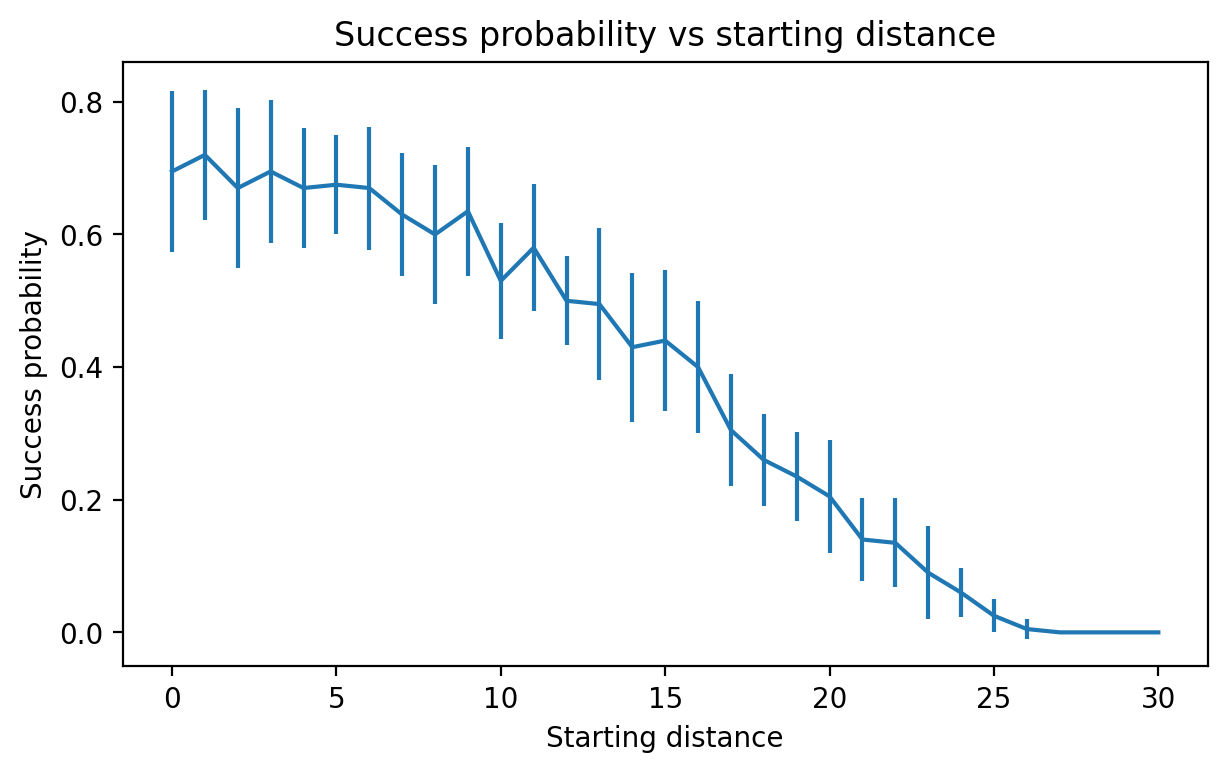

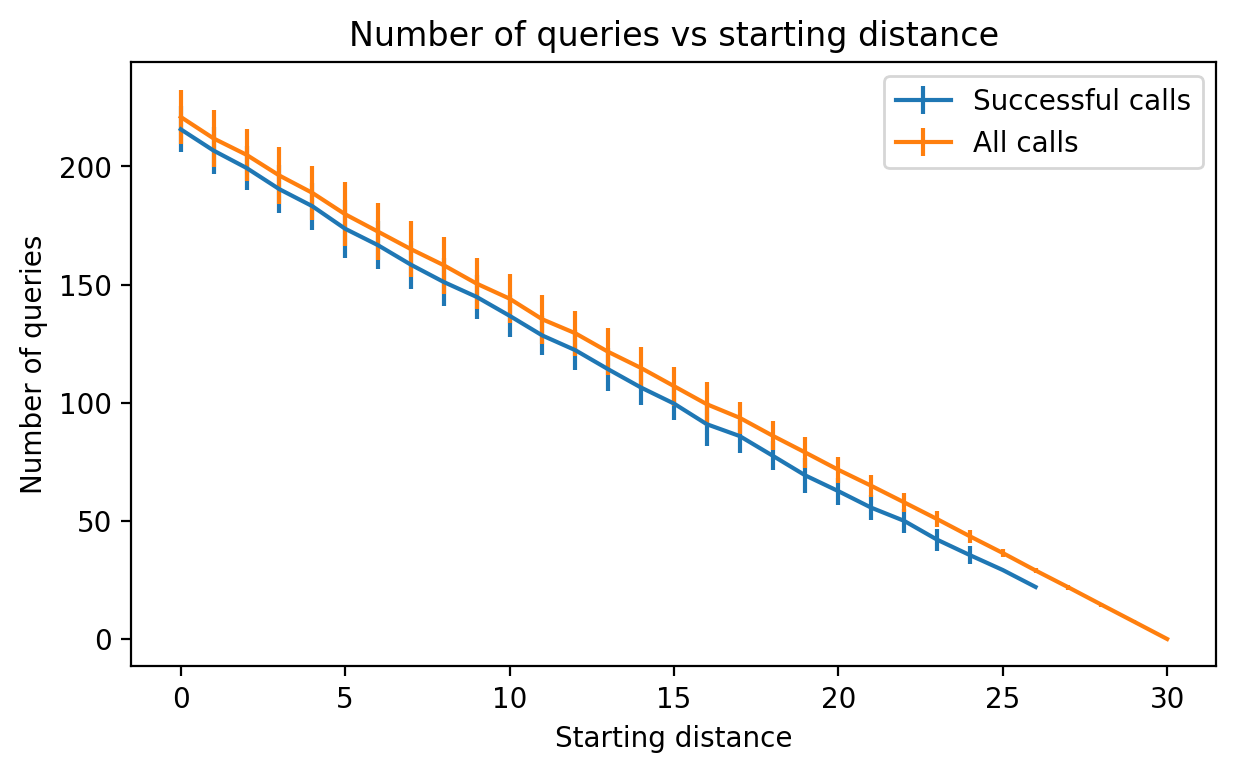

In [39]:
dist_grid = lsh_params['r1'] - t_grid
xlims = (np.min(dist_grid) - 1, np.max(dist_grid) + 1)

plt.errorbar(dist_grid, data_succ_prob[0], yerr=data_succ_prob[1])
# plt.xlim(xlims)
plt.title("Success probability vs starting distance")
plt.xlabel("Starting distance")
plt.ylabel("Success probability")
plt.show()

plt.errorbar(dist_grid, data_queries[0], yerr=data_queries[1], label="Successful calls")
plt.errorbar(dist_grid, data_all_queries[0], yerr=data_all_queries[1], label="All calls")
plt.legend()
# plt.xlim(xlims)
plt.title("Number of queries vs starting distance")
plt.xlabel("Starting distance")
plt.ylabel("Number of queries")
plt.show()

### Analysing dependance on radius

In [3]:
env = Environment()

point_params = {
    'n': 1000,
    'd': 300,
    'point_type': "zero",
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/50,
    'seed_offset': 0,
    'r1': point_params['d'] // 10,
    'r2': point_params['d'] // 5
}

exp_params = {
    'alg_type': 'adaptive',
    'iter_num': 1000,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
}

In [46]:
grid = np.arange(0, lsh_params['r1'], 1)
res = run_basic_grid_experiment(grid, 'target_distance', env, point_params, lsh_params, exp_params, data_dir=DATA_DIR)

  0%|          | 0/30 [00:00<?, ?it/s]

In [47]:
data_succ_prob, data_queries = process_results(res, count_failures=False)
_, data_all_queries = process_results(res, count_failures=True)

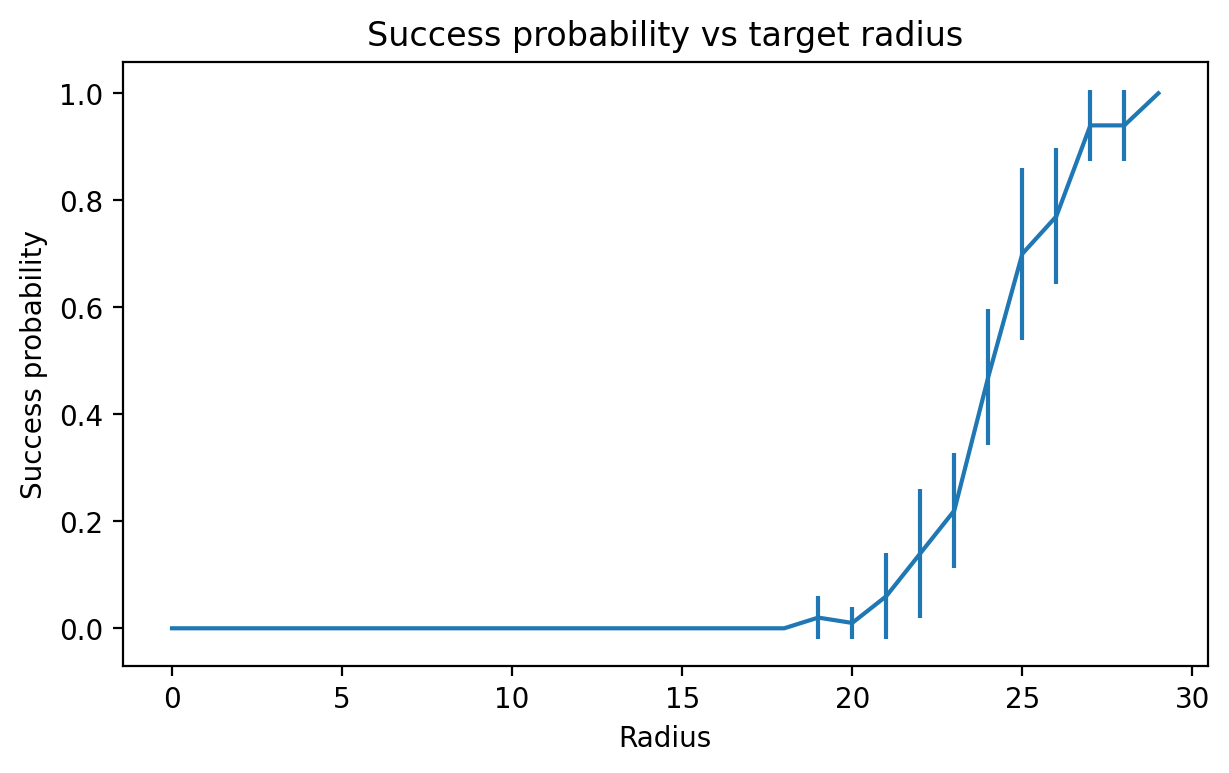

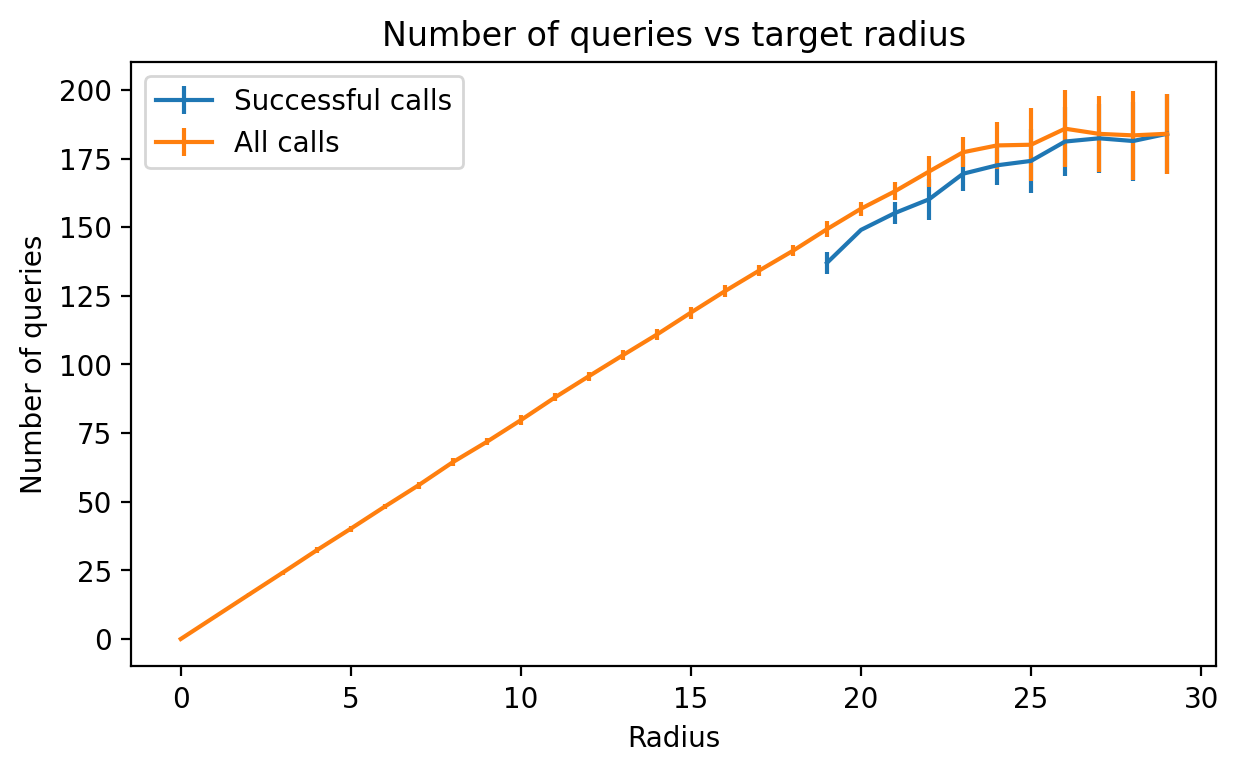

In [48]:
plt.errorbar(grid, data_succ_prob[0], yerr=data_succ_prob[1])
# plt.xlim(xlims)
plt.title("Success probability vs target radius")
# plt.yscale("log")
plt.xlabel("Radius")
plt.ylabel("Success probability")
plt.show()

plt.errorbar(grid, data_queries[0], yerr=data_queries[1], label="Successful calls")
plt.errorbar(grid, data_all_queries[0], yerr=data_all_queries[1], label="All calls")
plt.legend()
# plt.xlim(xlims)
plt.title("Number of queries vs target radius")
plt.xlabel("Radius")
plt.ylabel("Number of queries")
plt.show()

### Search for infliction point

In [30]:
env = Environment()

point_params = {
    'n': 1000,
    'd': 300,
    'point_type': "zero",
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/np.e,
    'seed_offset': 0,
    'r1': point_params['d'] // 10,
    'r2': point_params['d'] // 5
}

exp_params = {
    'alg_type': 'adaptive',
    'iter_num': 100,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
}

In [31]:
delta_list = np.exp(-np.arange(1, 14, 3),)
grid = np.arange(0, lsh_params['r2'], 1)

all_res = []

for dl in delta_list:
    new_lsh_params = lsh_params.copy()
    new_lsh_params['delta'] = dl
    res = run_basic_grid_experiment(grid, 'target_distance', env, point_params, new_lsh_params, exp_params, data_dir=DATA_DIR)
    data_succ_prob, _ = process_results(r_res, count_failures=True)
    all_res.append(res)

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

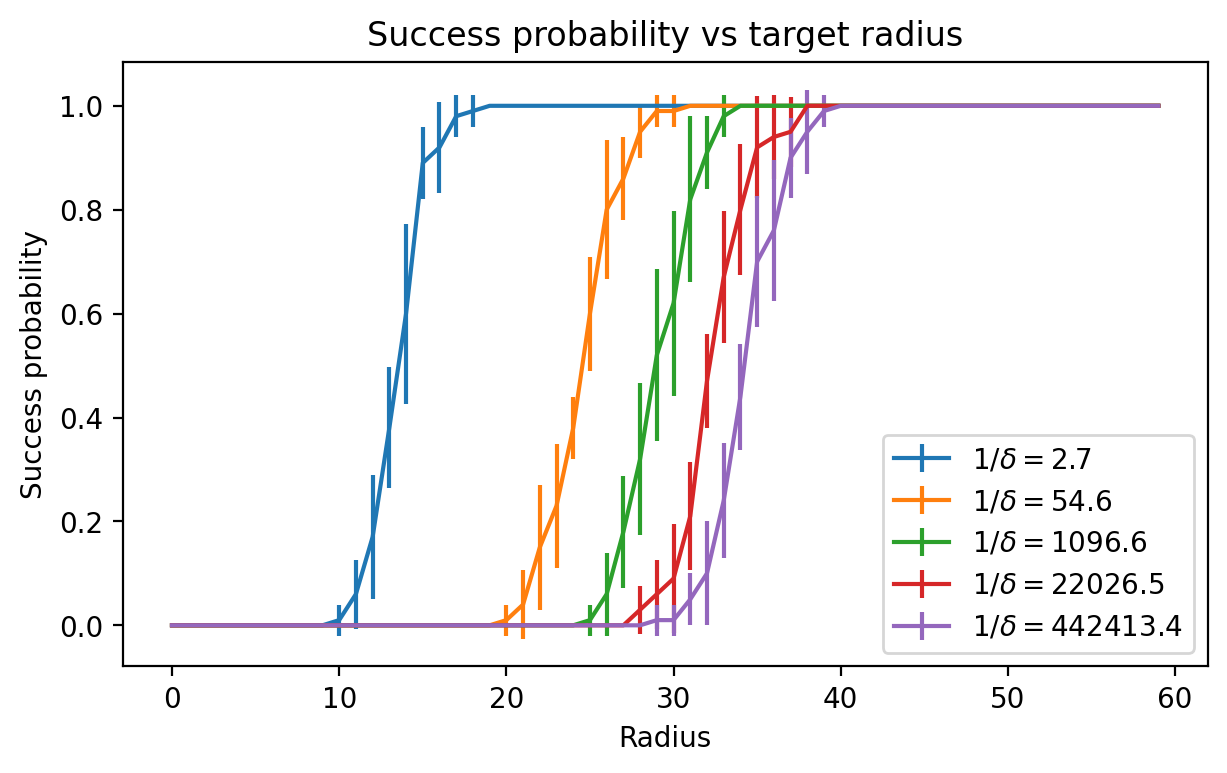

In [45]:
for r_res, dl in zip(all_res, delta_list):
    data_succ_prob, _ = process_results(r_res, count_failures=True)
    plt.errorbar(grid, data_succ_prob[0], yerr=data_succ_prob[1], label=f"$1/\delta={1/dl:.1f}$")
    
plt.title(f"Success probability vs target radius")
plt.legend()
# plt.ylim(-0.1, 1.1)
plt.xlabel("Radius")
plt.ylabel("Success probability")
plt.show()


### Success probability vs number of hash functions

In [25]:
l_list = np.linspace(1, 500, 20, endpoint=True)
points = np.zeros((n, d), dtype=int)
nn_checker = skln.KDTree(points, metric='l1')

l_all_res = []

for cur_l in tqdm(l_list):
    iters_per_point = 300
    cur_res = []
    for i in range(iters_per_point):
        lsh = HammingLSH(points, r1, r2, l=int(cur_l))
        cur_res.append(run_exp_fast(r1))
    l_all_res.append(cur_res)

  0%|          | 0/20 [00:00<?, ?it/s]

In [26]:
failure_prob = []
mean_queries = np.zeros(len(l_all_res))
err_queries = np.zeros(len(l_all_res))
# bars_queries = [np.zeros(len(r_res)), np.zeros(len(r_res))]
for i, v in enumerate(l_all_res):
    f_pr = sum(1 - e[0] for e in v) / len(v)
    failure_prob.append(f_pr)
    queries = [e[1] for e in v]
    mean_queries[i] = np.mean(queries)
#     bars_queries[0][i] = np.percentile(queries, 90)
#     bars_queries[1][i] = np.percentile(queries, 10)
    err_queries[i] = np.std(queries)


# bars_queries[0] -= mean_queries
# bars_queries[1] = mean_queries - bars_queries[1]

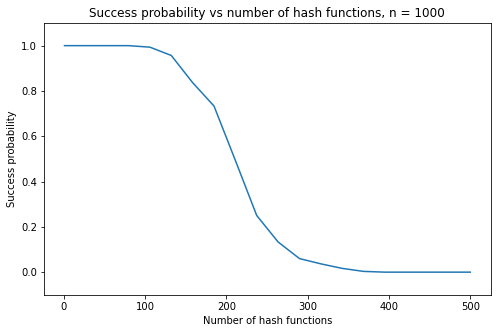

In [33]:
plt.plot(l_list, 1 - np.array(failure_prob))
plt.title(f"Success probability vs number of hash functions, n = {n}")
plt.ylim(-0.1, 1.1)
# plt.yscale("log")
# plt.xscale("log")
plt.xlabel("Number of hash functions")
plt.ylabel("Success probability")
plt.show()

### Number of queries vs $1/\delta$

In [57]:
env = Environment()

point_params = {
    'n': 1000,
    'd': 300,
    'point_type': "zero",
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/np.e,
    'seed_offset': 0,
    'r1': point_params['d'] // 10,
    'r2': point_params['d'] // 5
}

exp_params = {
    'alg_type': 'adaptive',
    'iter_num': 500,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
    'max_queries': 80000,
    'max_resamples': 40000,
}

In [58]:
delta_list = np.logspace(1, 8, 8, endpoint=True, base=1/np.e)    

delta_adapt_res = []

# for cur_delta in tqdm(delta_list):
#     iters_per_point = 100
#     cur_res = []
#     for i in range(iters_per_point):
#         lsh = HammingLSH(points, r1, r2, delta=cur_delta)
#         cur_res.append(run_exp_fast(points[0], r1, nn_checker, lsh, max_resamples=30))
#     delta_res.append(cur_res)

for dl in tqdm(delta_list):
    new_lsh_params = lsh_params.copy()
    new_lsh_params['delta'] = dl
    cur_res = run_experiments(env, point_params, new_lsh_params, exp_params, data_dir=DATA_DIR)
    delta_adapt_res.append(cur_res)

  0%|          | 0/8 [00:00<?, ?it/s]

In [59]:
delta_list = np.logspace(1, 8, 8, endpoint=True, base=1/np.e)    
delta_rand_res = []

for dl in tqdm(delta_list):
    new_lsh_params = lsh_params.copy()
    new_lsh_params['delta'] = dl
    new_exp_params = exp_params.copy()
    new_exp_params['alg_type'] = 'random'
    cur_res = run_experiments(env, point_params, new_lsh_params, new_exp_params, data_dir=DATA_DIR)
    delta_rand_res.append(cur_res)

  0%|          | 0/8 [00:00<?, ?it/s]

In [60]:
adapt_succ_prob, adapt_queries = process_results(delta_adapt_res, count_failures=True)
rand_succ_prob, rand_queries = process_results(delta_rand_res, count_failures=True)

In [61]:
rand_queries

(array([3.162000e+00, 1.112800e+01, 3.421600e+01, 9.625800e+01,
        2.562880e+02, 9.242060e+02, 2.601148e+03, 7.906528e+03]),
 array([2.61682174e+00, 1.07899776e+01, 3.19073870e+01, 9.44856150e+01,
        2.70828738e+02, 8.81013198e+02, 2.33796358e+03, 8.07983571e+03]))

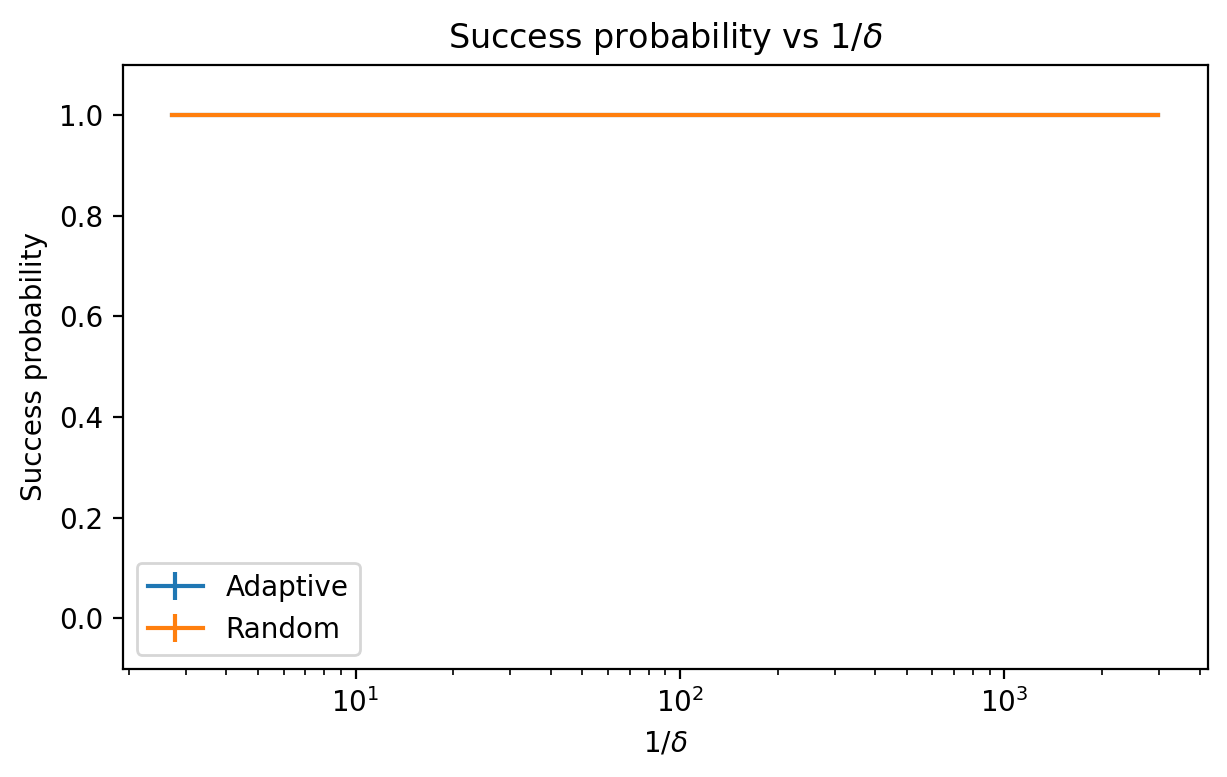

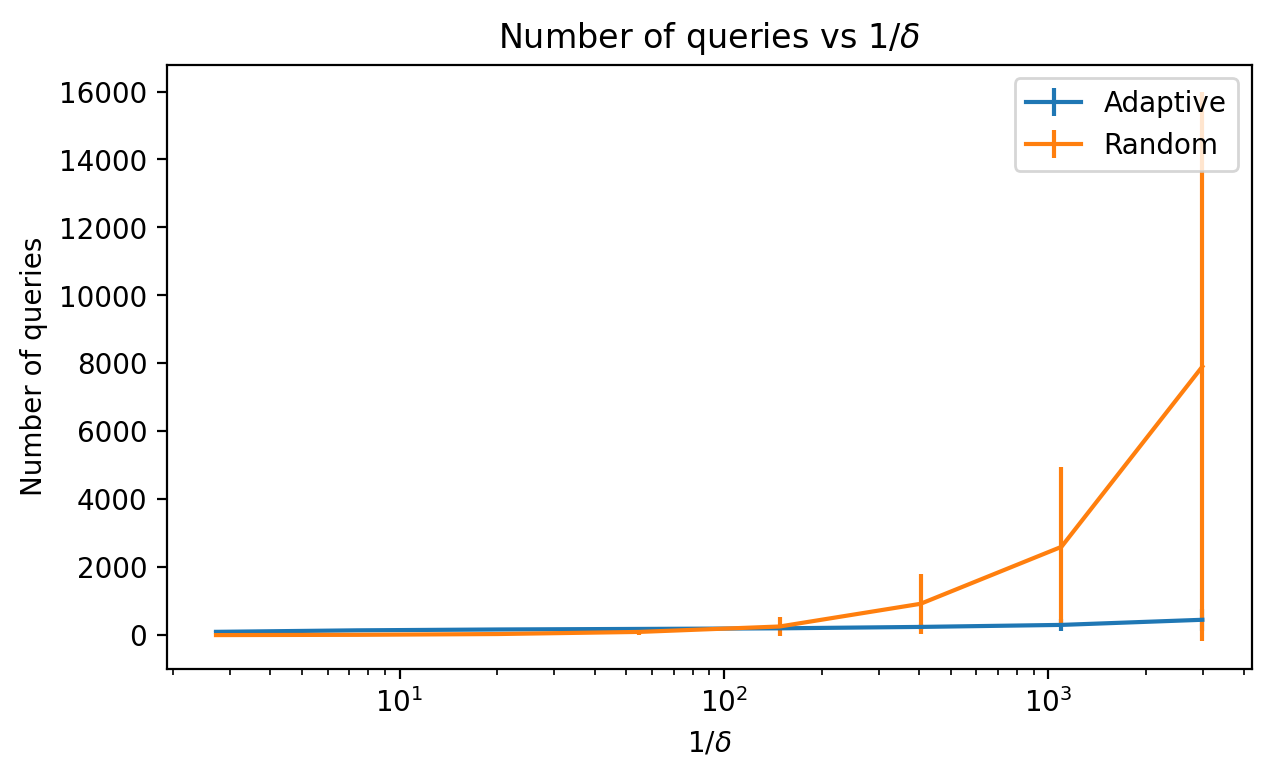

In [62]:
plt.errorbar(1 / delta_list, adapt_succ_prob[0], yerr=adapt_succ_prob[1], label="Adaptive")
plt.errorbar(1 / delta_list, rand_succ_prob[0], yerr=rand_succ_prob[1], label="Random")
plt.legend()
plt.title(f"Success probability vs $1/\delta$")
plt.ylim(-0.1, 1.1)
# plt.yscale("log")
plt.xscale("log")
plt.xlabel("$1 / \delta$")
plt.ylabel("Success probability")
plt.show()

plt.errorbar(1 / delta_list, adapt_queries[0], yerr=adapt_queries[1], label="Adaptive")
plt.errorbar(1 / delta_list, rand_queries[0], yerr=rand_queries[1], label="Random")
# plt.plot(1 / delta_list, rand_mean_queries / (1 - np.array(rand_failure_prob)), label="Random projected")
plt.legend()
plt.title(f"Number of queries vs $1/\delta$")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$1 / \delta$")
plt.ylabel("Number of queries")
plt.show()

# plt.errorbar(1 / delta_list, mean_queries, yerr=err_queries, label="Adaptive")
# plt.errorbar(1 / delta_list, rand_mean_queries, yerr=rand_err_queries, label="Random")
# plt.plot(1 / delta_list, rand_mean_queries / (1 - np.array(rand_failure_prob)), label="Random projected")
# plt.legend()
# plt.title(f"Number of queries vs $1/\delta$, n = {n}")
# # plt.yscale("log")
# plt.xscale("log")
# plt.xlabel("$1 / \delta$")
# plt.ylabel("Number of queries")
# plt.show()

# Size of $G(q,z)$

In [6]:
t = 10

In [7]:
print(r1, r2, t, n, d)

30 60 10 1000 300


In [11]:
points = np.zeros((n, d))

z = np.zeros(d)

In [29]:
grid = np.arange(0, r2)

num_samples = 10
res = []
for dist in tqdm(grid):
    q = np.zeros(d)
    q[:dist] = 1
    cur_res = []
    for i in range(num_samples):
        lsh = HammingLSH(points, r1, r2, delta)
        cur_res.append(lsh.cnt_mutual_buckets(q, z))
    res.append(cur_res)

  0%|          | 0/60 [00:00<?, ?it/s]

In [40]:
frac_res = np.array(res) / lsh._l
means = np.mean(frac_res, axis=1)
err = np.std(frac_res, axis=1)

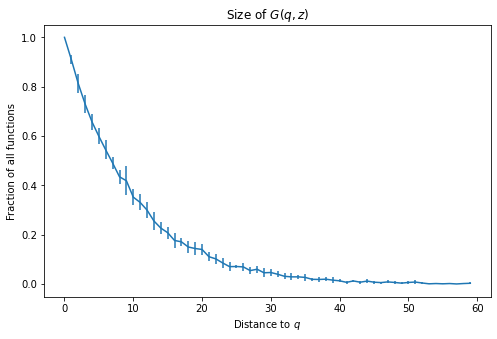

In [42]:
plt.errorbar(grid, means, yerr=err)
# plt.yscale("log")
plt.title("Size of $G(q, z)$")
plt.xlabel("Distance to $q$")
plt.ylabel("Fraction of all functions")
plt.show()